In [2]:
import numpy as np

import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

In [3]:
class HH(bp.dyn.NeuDyn):
  def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36., EL=-54.387, gL=0.03,
               V_th=20., C=1.0, **kwargs):
    # providing the group "size" information
    super(HH, self).__init__(size=size, **kwargs)

    # initialize parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.C = C
    self.V_th = V_th

    # initialize variables
    self.V = bm.Variable(bm.random.randn(self.num) - 70.)
    self.m = bm.Variable(0.0266 * bm.ones(self.num))
    self.h = bm.Variable(0.772 * bm.ones(self.num))
    self.n = bm.Variable(0.235 * bm.ones(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

    # integral functions
    self.int_V = bp.odeint(f=self.dV, method='exp_auto')
    self.int_m = bp.odeint(f=self.dm, method='exp_auto')
    self.int_h = bp.odeint(f=self.dh, method='exp_auto')
    self.int_n = bp.odeint(f=self.dn, method='exp_auto')

  def dV(self, V, t, m, h, n, Iext):
    I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
    I_K = (self.gK * n ** 4.0) * (V - self.EK)
    I_leak = self.gL * (V - self.EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / self.C
    return dVdt

  def dm(self, m, t, V):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m
    return dmdt
  
  def dh(self, h, t, V):
    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h
    return dhdt

  def dn(self, n, t, V):
    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n
    return dndt

  def update(self, x=None):
    _t = bp.share['t']
    _dt = bp.share['dt']
    x = 0. if x is None else x
    
    # compute V, m, h, n
    V = self.int_V(self.V, _t, self.m, self.h, self.n, x, dt=_dt)
    self.h.value = self.int_h(self.h, _t, self.V, dt=_dt)
    self.m.value = self.int_m(self.m, _t, self.V, dt=_dt)
    self.n.value = self.int_n(self.n, _t, self.V, dt=_dt)

    # update the spiking state and the last spiking time
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.t_last_spike.value = bm.where(self.spike, _t, self.t_last_spike)

    # update V
    self.V.value = V

In [4]:
current, length = bp.inputs.section_input(values=[0., bm.asarray([1., 2., 4., 8., 10., 15]), 0.], durations=[10,2,25], return_length=True)
hh_neurons = HH(current.shape[1])
runner = bp.DSRunner(hh_neurons, monitors=['V', 'm', 'h', 'n'])
runner.run(inputs=current)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/370 [00:00<?, ?it/s]

Text(0.5, 0, 'Time (ms)')

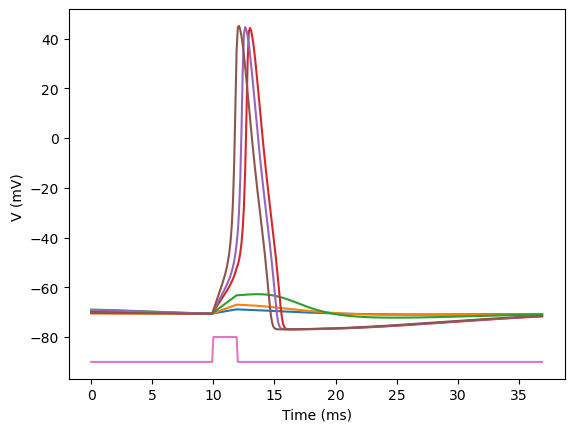

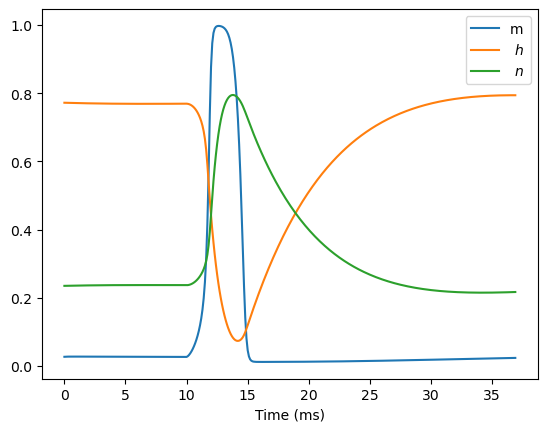

In [5]:
import matplotlib.pyplot as plt
bp.visualize.line_plot(runner.mon.ts, runner.mon.V, ylabel='V (mV) ', plot_ids=np.arange(current.shape[1]))
plt.plot(runner.mon.ts, bm.where(current[:,-1]>0,10,0) -90.)
plt.figure()
plt.plot(runner.mon.ts, runner.mon.m[:, -1])
plt.plot(runner.mon.ts, runner.mon.h[:, -1])
plt.plot(runner.mon.ts, runner.mon.n[:, -1])
plt. legend (['m', ' $h$ ', ' $n$ '])
plt.xlabel('Time (ms)')